ENVIRONMENT PREPARATION

In [ ]:
#menginstall library osmnx (source : Stack Exchange)
#karena  osmnx tidak ada di google colab secara default
!apt-get -qq install -y libspatialindex-dev && pip install -q -U osmnx

Selecting previously unselected package libspatialindex4v5:amd64.
(Reading database ... 144487 files and directories currently installed.)
Preparing to unpack .../libspatialindex4v5_1.8.5-5_amd64.deb ...
Unpacking libspatialindex4v5:amd64 (1.8.5-5) ...
Selecting previously unselected package libspatialindex-c4v5:amd64.
Preparing to unpack .../libspatialindex-c4v5_1.8.5-5_amd64.deb ...
Unpacking libspatialindex-c4v5:amd64 (1.8.5-5) ...
Selecting previously unselected package libspatialindex-dev:amd64.
Preparing to unpack .../libspatialindex-dev_1.8.5-5_amd64.deb ...
Unpacking libspatialindex-dev:amd64 (1.8.5-5) ...
Setting up libspatialindex4v5:amd64 (1.8.5-5) ...
Setting up libspatialindex-c4v5:amd64 (1.8.5-5) ...
Setting up libspatialindex-dev:amd64 (1.8.5-5) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
/sbin/ldconfig.real: /usr/local/lib/python3.6/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 92kB 2.9MB/s 
     |

In [ ]:
#mengkoneksikan google drive dan colab notebook
#ini dilakukan agar data di drive dapat dimuat di google colab
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#mengimport library yang dibutuhkan

import pandas as pd
import numpy as np
import math
import osmnx as ox
import networkx as nx
from IPython.display import HTML
import folium

In [ ]:
#mendapatkan direktori data
directory = r'/content/drive/My Drive/Colab Notebooks/Internship/(RAPIH)DATA SURVEY LAPANGAN.xlsx'

#mengambil data dari dua sheet berbeda
#sheet pertama : data barang, harga barang, dan tokonya
df_0 = pd.read_excel(directory,sheet_name=0)

#sheet kedua : data toko dan kecamatan tempat toko berada
df_2 = pd.read_excel(directory,sheet_name=2)

In [ ]:
#menampilkan data yang akan diolah
df_0.head()

,NO,ITEM,JENIS MATERIAL,KETERANGAN,SATUAN,HARGA SATUAN DASAR,Toko Bahan Bangunan / Ahmad,Toko Fajar Bangunan,Toko Berdikari,Toko Dewi Sinta,Toko Tiga Roda,Toko Bahan Bangunan Banjar,Toko terus Jaya,Toko Bangunan Mandiri,Toko Sumber Jaya Bangunan,Toko Cahaya Tani,PD. Karunia Jaya,Barokah Pembangunan,TB. Prima / Ranran,Harapan Putra,TB. Tujuh Warna,PD. Asli Jaya / Cecep,Cahaya Tani,Anugrah Wijaya,Surya Mandala,Toko Sumber Rizki / Haji eneng,PD. Tani Andalan /H.Rusdi,Toko Sumber Jaya,PB. Repelita Bangunan,PD.Rizal Makmur Jaya,TB. Irfan,PB. Riskia Putra,PD. Maju Bersama / M. Rusdi,TB. Bangunan Raya,Mitra Bangunan,Toko ABC,Toko Berkah / H.Agus,Bangkuyung Putra / H.Uju,CV Mulya Rahayu,Dinda,Min,Maks,RATA-RATA
0,1,Bata Merah,"BATA, BATU DAN PASIR",uk. 5 x 11x 22 cm,bh,600,500.0,500.0,500.0,500.0,500.0,500.0,500.0,480.0,480.0,500.0,500.0,500.0,500.0,500.0,500.0,600.0,500.0,650.0,500.0,500.0,550.0,600.0,500.0,800.0,NaN,600.0,500.0,400.0,NaN,500.0,500.0,500.0,500.0,NaN,400,800,521.290323
1,2,Bata beton ringan ex Celcon,"BATA, BATU DAN PASIR",uk. 9 x 19 x 39 cm,bh,4500,3800.0,4300.0,3800.0,4000.0,4300.0,4000.0,4600.0,4200.0,4000.0,4200.0,4000.0,4000.0,4600.0,4200.0,NaN,NaN,3800.0,4000.0,4300.0,4300.0,4600.0,4300.0,3600.0,4600.0,NaN,4200.0,4600.0,3600.0,NaN,NaN,4600.0,4300.0,4600.0,5000.0,3600,5000,4220.689655
2,3,Batu kali,"BATA, BATU DAN PASIR",Batu belah pondasi,m3,215000,200000.0,160000.0,200000.0,160000.0,200000.0,130000.0,140000.0,90000.0,200000.0,240000.0,NaN,40000.0,NaN,48000.0,NaN,180000.0,NaN,122000.0,NaN,NaN,140000.0,120000.0,120000.0,180000.0,NaN,120000.0,NaN,120000.0,NaN,200000.0,NaN,300000.0,140000.0,NaN,40000,300000,177500.000000
3,4,Batu Split Pecah Mesin 1/2,"BATA, BATU DAN PASIR",NaN,m3,240000,240000.0,250000.0,240000.0,200000.0,250000.0,250000.0,260000.0,500000.0,250000.0,300000.0,350000.0,250000.0,250000.0,300000.0,300000.0,250000.0,350000.0,400000.0,350000.0,350000.0,360000.0,800000.0,700000.0,750000.0,NaN,600000.0,250000.0,800000.0,NaN,250000.0,250000.0,250000.0,200000.0,NaN,200000,800000,358064.516129
4,5,Batu Split Pecah Mesin 3/5,"BATA, BATU DAN PASIR",NaN,m3,235000,240000.0,250000.0,NaN,200000.0,250000.0,NaN,NaN,NaN,250000.0,NaN,200000.0,250000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,250000.0,NaN,NaN,NaN,NaN,250000.0,200000.0,NaN,200000,250000,234000.000000


In [ ]:
#menampilkan data yang akan diolah
df_2.head()

,NAMA TOKO,KECAMATAN
0,Anugrah Wijaya,"Angsana, Pandeglang"
1,Toko Bahan Bangunan Banjar,"Banjar, Pandeglang"
2,Surya Mandala,"Bojong, Pandeglang"
3,Toko Bahan Bangunan / Ahmad,"Cadasari, Pandeglang"
4,Toko Berkah / H.Agus,"Carita, Pandeglang"


In [ ]:
#mengganti nama kolom menjadi "NAMA_TOKO" untuk memudahkan akses di kode selanjutnya
df_2.rename(columns = {"NAMA TOKO" : "NAMA_TOKO"}, inplace= True)

PENGAMBILAN DATA GEOGRAFIS YANG DIPERLUKAN

In [ ]:
#inisiasi list untuk menyimpan koordinat kecamatan dalam format : (lat,long) 
#atau disebut juga point
point_tuple = []

#inisiasi list untuk melihat kecamatan yang terdeteksi
data_availability = []

#inisiasi list untuk mengetahui kecamatan-kecamatan yang tidak terdeteksi
unavailable_store = []
for address in df_2.KECAMATAN:
  
  #mencoba mendapatkan point dari kecamatan menggunakan
  # fungsi point_tuple.append(ox.geocode(address)) dari osmnx
  try:
    point_tuple.append(ox.geocode(address))
    data_availability.append(True)
    unavailable_store.append(False)
  
  #operasi yang dilakukan jika point_tuple.append(ox.geocode(address)) tidak
  #menemukan point dari kecamatan
  except:
    data_availability.append(False)
    unavailable_store.append(True)

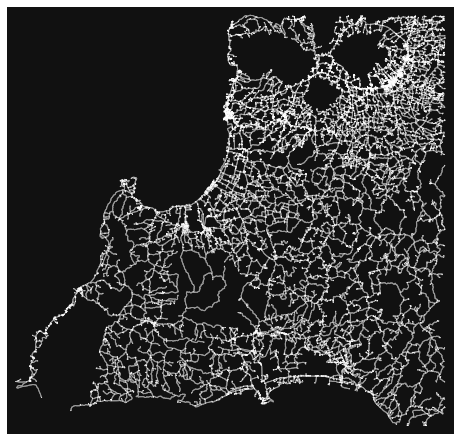

In [ ]:
#mendapatkan pandeglang area dengan osmnx
graph = ox.graph_from_bbox(-6.2143,-6.8801,106.1815,105.1996, network_type="drive")

# menambahkan data kecepatan (km per hour) pada setiap edge
# karena akan digunakan untuk mencari jalur dengan waktu tempuh tercepat
graph = ox.add_edge_speeds(graph)

# menghitung waktu perjalanan (dalam detik) untk semua edge
graph = ox.add_edge_travel_times(graph)

#menampilkan map yang didapatkan
fig, ax = ox.plot_graph(graph,node_size= 1)


CLEANSING DATA

In [ ]:
#load data toko dan kecamatan dengan meniadakan toko-toko tanpa point
df_2_clean = df_2[data_availability].copy()

#reset index agara dataframe terlihat lebih rapih
df_2_clean.reset_index(drop = True, inplace = True)

#menambahkan koordinat setiap kecamatan pada kolom baru, yaitu 'POINT'
df_2_clean['POINT'] = point_tuple

#mencari node terdekat dari point, karena node akan digunakan
#untuk mencari waktu tempuh tercepat menggunakan osmnx
regency_node = [ox.get_nearest_node(graph, i, method='euclidean')\
                    for i in df_2_clean.POINT]

#menambahkan node setiap kecamatan pada kolom baru, yaitu 'NEAREST_NODE'
df_2_clean["NEAREST_NODE"] = regency_node

#menghapus variabel yang tidak akan digunakan lagi
del(data_availability, point_tuple, regency_node)

#menampilkan hasil cleansing dan penambahan kolom dari data df_2
df_2_clean

,NAMA_TOKO,KECAMATAN,POINT,NEAREST_NODE
0,Anugrah Wijaya,"Angsana, Pandeglang","(-6.5629566, 105.8648152)",6630264884
1,Toko Bahan Bangunan Banjar,"Banjar, Pandeglang","(-6.383913, 106.0936389)",7122161452
2,Surya Mandala,"Bojong, Pandeglang","(-6.4432148, 105.9976546)",7117490169
3,Toko Bahan Bangunan / Ahmad,"Cadasari, Pandeglang","(-6.2664793, 106.1181947)",6295313070
4,Toko Berkah / H.Agus,"Carita, Pandeglang","(-6.3146901, 105.8459414)",4356581857
5,TB. Irfan,"Cibaliung, Pandeglang","(-6.7224166, 105.7479821)",6159348529
6,PB. Riskia Putra,"Cibitung, Pandeglang","(-6.6272469, 105.8869424)",6227740169
7,PD.Rizal Makmur Jaya,"Cikeusik, Pandeglang","(-6.7098719, 105.8745772)",1925926683
8,Dinda,"Cimanggu, Pandeglang","(-6.6789151, 105.6545716)",7466156701
9,Toko Bangunan Mandiri,"Cimanuk, Pandeglang","(-6.3743304, 106.0283358)",6217382600


In [ ]:
#menampilkan peta kota pandeglang 

#mendapatkan data yang diperlukan dari dataframe untuk ditampilkan di peta,
#yaitu titik koordinat kecamatan dan nama kecamatannya
kecamatan_latlong = dict(zip(df_2_clean.KECAMATAN, df_2_clean.POINT))

#mendapatkan peta yang menunjuk ke kabupaten pandeglang menggunakan folium
peta_pandeglang = folium.Map(location = [-6.518535,105.7921803], zoom_start=10)

#menyimpan penanda kecamatan pada peta
for i in kecamatan_latlong.items():
  folium.Marker(i[1],popup = i[0]).add_to(peta_pandeglang)

#membuat frame untuk peta dengan ukuran 600 x 600 pixel
map = folium.Figure(width=600,height=600,)

#menginput peta pada frame
peta_pandeglang.add_to(map)

#menampilkan peta
map

Dari peta, terlihat bahwa untuk titik "Labuan, Pandeglang" ada kekeliruan, karena titiknya malah berada pada kota Pandeglang, maka kita akan ubah titik koordinat dari kecamatan Labuan dengan mencari titik koordinat yang lebih akurat  secara manual lewat google maps

In [ ]:
df_2_clean

,NAMA_TOKO,KECAMATAN,POINT,NEAREST_NODE
0,Anugrah Wijaya,"Angsana, Pandeglang","(-6.5629566, 105.8648152)",6630264884
1,Toko Bahan Bangunan Banjar,"Banjar, Pandeglang","(-6.383913, 106.0936389)",7122161452
2,Surya Mandala,"Bojong, Pandeglang","(-6.4432148, 105.9976546)",7117490169
3,Toko Bahan Bangunan / Ahmad,"Cadasari, Pandeglang","(-6.2664793, 106.1181947)",6295313070
4,Toko Berkah / H.Agus,"Carita, Pandeglang","(-6.3146901, 105.8459414)",4356581857
5,TB. Irfan,"Cibaliung, Pandeglang","(-6.7224166, 105.7479821)",6159348529
6,PB. Riskia Putra,"Cibitung, Pandeglang","(-6.6272469, 105.8869424)",6227740169
7,PD.Rizal Makmur Jaya,"Cikeusik, Pandeglang","(-6.7098719, 105.8745772)",1925926683
8,Dinda,"Cimanggu, Pandeglang","(-6.6789151, 105.6545716)",7466156701
9,Toko Bangunan Mandiri,"Cimanuk, Pandeglang","(-6.3743304, 106.0283358)",6217382600


In [ ]:
#menginput data koordinat kecamatan Labuan
#yang didapatkan lewat google maps
point_baru = (-6.3668947,105.8326248) 

#mengganti point lama dengan point baru
df_2_clean.at[13, 'POINT'] = point_baru
df_2_clean

,NAMA_TOKO,KECAMATAN,POINT,NEAREST_NODE
0,Anugrah Wijaya,"Angsana, Pandeglang","(-6.5629566, 105.8648152)",6630264884
1,Toko Bahan Bangunan Banjar,"Banjar, Pandeglang","(-6.383913, 106.0936389)",7122161452
2,Surya Mandala,"Bojong, Pandeglang","(-6.4432148, 105.9976546)",7117490169
3,Toko Bahan Bangunan / Ahmad,"Cadasari, Pandeglang","(-6.2664793, 106.1181947)",6295313070
4,Toko Berkah / H.Agus,"Carita, Pandeglang","(-6.3146901, 105.8459414)",4356581857
5,TB. Irfan,"Cibaliung, Pandeglang","(-6.7224166, 105.7479821)",6159348529
6,PB. Riskia Putra,"Cibitung, Pandeglang","(-6.6272469, 105.8869424)",6227740169
7,PD.Rizal Makmur Jaya,"Cikeusik, Pandeglang","(-6.7098719, 105.8745772)",1925926683
8,Dinda,"Cimanggu, Pandeglang","(-6.6789151, 105.6545716)",7466156701
9,Toko Bangunan Mandiri,"Cimanuk, Pandeglang","(-6.3743304, 106.0283358)",6217382600


In [ ]:
#menampilkan peta kota pandeglang 

#mendapatkan data yang diperlukan dari dataframe untuk ditampilkan di peta,
#yaitu titik koordinat kecamatan dan nama kecamatannya
kecamatan_latlong = dict(zip(df_2_clean.KECAMATAN, df_2_clean.POINT))

#mendapatkan peta yang menunjuk ke kabupaten pandeglang menggunakan folium
peta_pandeglang = folium.Map(location = [-6.518535,105.7921803], zoom_start=10)

#menyimpan penanda kecamatan pada peta
for i in kecamatan_latlong.items():
  folium.Marker(i[1],popup = i[0]).add_to(peta_pandeglang)

#membuat frame untuk peta dengan ukuran 600 x 600 pixel
map = folium.Figure(width=600,height=600,)

#menginput peta pada frame
peta_pandeglang.add_to(map)

#menampilkan peta
map

In [ ]:
#menampilkan kecamatan yang tidak terdeteksi oleh osmnx
extra_kecamatan = df_2[unavailable_store].KECAMATAN.copy().to_list()
extra_kecamatan

['Cicadas, Pandeglang',
 'Cigeulis, Pandeglang',
 'Cikedal, Pandeglang',
 'Cipeucang, Pandeglang',
 'Cisata, Pandeglang',
 'Majasari, Pandeglang',
 'Panimbang, Pandeglang',
 'Picung, Pandeglang',
 'Pulosari, Pandeglang',
 'Sobang, Pandeglang']

In [ ]:
#mendapatkan data koordinat dari tiap-tiap kecamatan
#agar data dari toko yang kecamatannya belum terdeteksi dapat digunankan


#data dari google maps diambil secara manual, 
#dimana urutan koordinat yang ada di bawah ini sama dengan urutan kecamatan
#yang ada pada data kecamatan sebelumnya
extra_point = [(-6.2987862,106.0902071),  #Cicadas, Pandeglang                  
 (-6.5861321,105.6897969),                #Cigeulis, Pandeglang    
 (-6.3912138,105.84665),                  #Cikedal, Pandeglang  
 (-6.3842172,105.9371791),                #Cipeucang, Pandeglang    
 (-6.3982853,105.8580781),                #Cisata, Pandeglang    
 (-6.3116788,106.0488),                   #Majasari, Pandeglang
 (-6.5229277,105.6557281),                #Panimbang, Pandeglang    
 (-6.4988811,105.8775087),                #Picung, Pandeglang    
 (-6.3318338,105.9028301),                #Pulosari, Pandeglang    
 (-6.6019904,105.6286981)]                #Sobang, Pandeglang    

#mendapatkan nama toko dari kecamatan-kecamtan yang tidak terdeteksi oleh osmnx
extra_toko = df_2[unavailable_store].NAMA_TOKO.copy().to_list()

#mencari node terdekat dari titik koordinat kecamtan, karena node akan digunakan
#untuk mencari waktu tempuh tercepat menggunakan osmnx
extra_node = [ox.get_nearest_node(graph, i, method='euclidean')\
                    for i in extra_point]

#membuat dataframe_extra dari semua data yang sudah diambil tadi
df_2_extra = pd.DataFrame(list(zip(extra_toko, extra_kecamatan,\
                                   extra_point, extra_node)), \
                          columns=["NAMA_TOKO","KECAMATAN", "POINT", "NEAREST_NODE"])

#menghapus data yang tidak akan digunakan lagi
del(extra_kecamatan, extra_point, extra_toko, unavailable_store, extra_node)

#menampilkan df_2_extra
df_2_extra

,NAMA_TOKO,KECAMATAN,POINT,NEAREST_NODE
0,Toko Berdikari,"Cicadas, Pandeglang","(-6.2987862, 106.0902071)",6641312031
1,CV Mulya Rahayu,"Cigeulis, Pandeglang","(-6.5861321, 105.6897969)",5974871405
2,TB. Tujuh Warna,"Cikedal, Pandeglang","(-6.3912138, 105.84665)",7117377128
3,Toko Sumber Jaya,"Cipeucang, Pandeglang","(-6.3842172, 105.9371791)",7437029552
4,Barokah Pembangunan,"Cisata, Pandeglang","(-6.3982853, 105.8580781)",6632364913
5,Toko Dewi Sinta,"Majasari, Pandeglang","(-6.3116788, 106.0488)",7120111496
6,Mitra Bangunan,"Panimbang, Pandeglang","(-6.5229277, 105.6557281)",6585186816
7,Toko Sumber Rizki / Haji eneng,"Picung, Pandeglang","(-6.4988811, 105.8775087)",6254180066
8,PD. Tani Andalan /H.Rusdi,"Pulosari, Pandeglang","(-6.3318338, 105.9028301)",6659424276
9,TB. Bangunan Raya,"Sobang, Pandeglang","(-6.6019904, 105.6286981)",1829441041


In [ ]:
df_2_new = pd.concat([df_2_clean, df_2_extra])

del(df_2_clean, df_2_extra)

df_2_new.sort_values(by="KECAMATAN", inplace= True)
df_2_new.reset_index(drop= True, inplace= True)
df_2_new

,NAMA_TOKO,KECAMATAN,POINT,NEAREST_NODE
0,Anugrah Wijaya,"Angsana, Pandeglang","(-6.5629566, 105.8648152)",6630264884
1,Toko Bahan Bangunan Banjar,"Banjar, Pandeglang","(-6.383913, 106.0936389)",7122161452
2,Surya Mandala,"Bojong, Pandeglang","(-6.4432148, 105.9976546)",7117490169
3,Toko Bahan Bangunan / Ahmad,"Cadasari, Pandeglang","(-6.2664793, 106.1181947)",6295313070
4,Toko Berkah / H.Agus,"Carita, Pandeglang","(-6.3146901, 105.8459414)",4356581857
5,TB. Irfan,"Cibaliung, Pandeglang","(-6.7224166, 105.7479821)",6159348529
6,PB. Riskia Putra,"Cibitung, Pandeglang","(-6.6272469, 105.8869424)",6227740169
7,Toko Berdikari,"Cicadas, Pandeglang","(-6.2987862, 106.0902071)",6641312031
8,CV Mulya Rahayu,"Cigeulis, Pandeglang","(-6.5861321, 105.6897969)",5974871405
9,TB. Tujuh Warna,"Cikedal, Pandeglang","(-6.3912138, 105.84665)",7117377128


In [ ]:
#menampilkan peta kota pandeglang 

#mendapatkan data yang diperlukan dari dataframe untuk ditampilkan di peta,
#yaitu titik koordinat kecamatan dan nama kecamatannya
kecamatan_latlong = dict(zip(df_2_new.KECAMATAN, df_2_new.POINT))

#mendapatkan peta yang menunjuk ke kabupaten pandeglang menggunakan folium
peta_pandeglang = folium.Map(location = [-6.518535,105.7921803], zoom_start=10)

#menyimpan penanda kecamatan pada peta
for i in kecamatan_latlong.items():
  folium.Marker(i[1],popup = i[0]).add_to(peta_pandeglang)

#membuat frame untuk peta dengan ukuran 600 x 600 pixel
map = folium.Figure(width=600,height=600,)

#menginput peta pada frame
peta_pandeglang.add_to(map)

#menampilkan peta
map

In [ ]:
#mengurutkan kolom agar urutan toko pada df_0_clean sama dengan 
#urutan toko pada df_2_clean
kolom_tersortir = df_0.columns[:6].to_list() + df_2_new.NAMA_TOKO.to_list()

#menyamakan urutan toko antara dua dataframe yang ada
df_0_clean = df_0[kolom_tersortir].copy()

#mendapatkan index dari barang yang tidak ada
#di semua toko pada dataframe
empty_index = df_0_clean[df_0_clean.columns[6:-3]].dropna(how = 'all').index

#meniadakan barang yang tidak tersedia di semua toko
df_0_clean = df_0_clean.iloc[empty_index]

#reset index agar lebih rapih
df_0_clean.reset_index(drop = True, inplace = True)

#menghapus variable yang tidak akan digunakan lagi
del(kolom_tersortir, empty_index)

#menampilkan data hasil cleansing
df_0_clean

,NO,ITEM,JENIS MATERIAL,KETERANGAN,SATUAN,HARGA SATUAN DASAR,Anugrah Wijaya,Toko Bahan Bangunan Banjar,Surya Mandala,Toko Bahan Bangunan / Ahmad,Toko Berkah / H.Agus,TB. Irfan,PB. Riskia Putra,Toko Berdikari,CV Mulya Rahayu,TB. Tujuh Warna,PD.Rizal Makmur Jaya,Dinda,Toko Bangunan Mandiri,Toko Sumber Jaya,Barokah Pembangunan,Bangkuyung Putra / H.Uju,Toko terus Jaya,Toko Tiga Roda,Toko ABC,Toko Dewi Sinta,Toko Fajar Bangunan,Cahaya Tani,TB. Prima / Ranran,Toko Cahaya Tani,Harapan Putra,Mitra Bangunan,PD. Maju Bersama / M. Rusdi,Toko Sumber Rizki / Haji eneng,PD. Tani Andalan /H.Rusdi,PD. Karunia Jaya,PD. Asli Jaya / Cecep,TB. Bangunan Raya,PB. Repelita Bangunan,Toko Sumber Jaya Bangunan
0,1,Bata Merah,"BATA, BATU DAN PASIR",uk. 5 x 11x 22 cm,bh,600,650.0,500.0,500.0,500.0,500.0,NaN,600.0,500.0,500.0,500.0,800.0,NaN,480.0,600.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,NaN,500.0,500.0,550.0,500.0,600.0,400.0,500.0,480.0
1,2,Bata beton ringan ex Celcon,"BATA, BATU DAN PASIR",uk. 9 x 19 x 39 cm,bh,4500,4000.0,4000.0,4300.0,3800.0,4600.0,NaN,4200.0,3800.0,4600.0,NaN,4600.0,5000.0,4200.0,4300.0,4000.0,4300.0,4600.0,4300.0,NaN,4000.0,4300.0,3800.0,4600.0,4200.0,4200.0,NaN,4600.0,4300.0,4600.0,4000.0,NaN,3600.0,3600.0,4000.0
2,3,Batu kali,"BATA, BATU DAN PASIR",Batu belah pondasi,m3,215000,122000.0,130000.0,NaN,200000.0,NaN,NaN,120000.0,200000.0,140000.0,NaN,180000.0,NaN,90000.0,120000.0,40000.0,300000.0,140000.0,200000.0,200000.0,160000.0,160000.0,NaN,NaN,240000.0,48000.0,NaN,NaN,NaN,140000.0,NaN,180000.0,120000.0,120000.0,200000.0
3,4,Batu Split Pecah Mesin 1/2,"BATA, BATU DAN PASIR",NaN,m3,240000,400000.0,250000.0,350000.0,240000.0,250000.0,NaN,600000.0,240000.0,200000.0,300000.0,750000.0,NaN,500000.0,800000.0,250000.0,250000.0,260000.0,250000.0,250000.0,200000.0,250000.0,350000.0,250000.0,300000.0,300000.0,NaN,250000.0,350000.0,360000.0,350000.0,250000.0,800000.0,700000.0,250000.0
4,5,Batu Split Pecah Mesin 3/5,"BATA, BATU DAN PASIR",NaN,m3,235000,NaN,NaN,NaN,240000.0,NaN,NaN,NaN,NaN,200000.0,NaN,NaN,NaN,NaN,NaN,250000.0,250000.0,NaN,250000.0,NaN,200000.0,250000.0,NaN,NaN,NaN,NaN,NaN,250000.0,NaN,NaN,200000.0,NaN,NaN,NaN,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,111,Outlet TV,PERALATAN ELEKTRIKAL,Broco,bh,12000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15000.0,5000.0,NaN,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,113,Down light / PLC 13 W,PERALATAN ELEKTRIKAL,NaN,bh,58000,58000.0,50000.0,NaN,NaN,NaN,NaN,85000.0,NaN,NaN,NaN,NaN,NaN,NaN,85000.0,NaN,NaN,45000.0,NaN,NaN,NaN,NaN,NaN,NaN,50000.0,50000.0,NaN,NaN,NaN,45000.0,NaN,45000.0,58000.0,NaN,NaN
106,114,Fitting plafond + lampu SL,PERALATAN ELEKTRIKAL,Panasonic,bh,14000,14000.0,20000.0,NaN,NaN,NaN,12000.0,13000.0,NaN,15000.0,NaN,NaN,20000.0,NaN,13000.0,15000.0,NaN,15000.0,NaN,NaN,NaN,NaN,NaN,NaN,15000.0,15000.0,NaN,NaN,NaN,15000.0,15000.0,2000.0,15000.0,NaN,NaN
107,115,Lampu TL 2 x 18 watt grille,PERALATAN ELEKTRIKAL,Panasonic,bh,42000,50000.0,NaN,40000.0,40000.0,49000.0,45000.0,40000.0,40000.0,NaN,45000.0,40000.0,40000.0,NaN,40000.0,35000.0,38000.0,NaN,45000.0,45000.0,NaN,45000.0,40000.0,49000.0,NaN,NaN,34000.0,49000.0,40000.0,47000.0,40000.0,40000.0,50000.0,45000.0,38000.0


In [ ]:
#menghapus data awal yang tidak akan digunakan lagi
#karena untuk selanjutnya hanya akan menggunakan data baru hasil cleansing
del(df_0, df_2)

PENGOLAHAN DATA

In [ ]:
#fungsi untuk menampilkan barang/kecamatan yang tersedia
#agar lebih mudah dilihat dengan cara menmbaginya menjadi beberapa kolom

def print_splitem (series, n, string_1, string_2) :
    
    #banyak item yang ditampilkan per kolom
    split_size = math.ceil(len(series)/n)
    
    #indeks item yang diambil dari dataframe : a:b
    a = 0
    b = split_size
    
    #inisiasi dictionary untuk dijadikan dataframe
    dict_reorg = {}
    
    #loop untuk membuat n-kolom dataframe
    for i in range(n):

      #mencetak kode untuk masing-masing barang
      dict_reorg[string_1+str(i+1)] = range(a+1, b+1)
      
      #mencetak barang-barang per kolom
      dict_reorg[string_2 + str(i+1)] = series[a:b].reset_index(drop= True).copy()
      
      #mendapatkan indeks data untuk kolom berikutnya
      a += split_size
      b += split_size
    
    #mengubah dictionary menjadi dataframe
    df_reorg = pd.DataFrame(dict_reorg)
    
    #mengganti nan values menjadi string kosong ('')
    df_reorg.replace(np.nan, '', regex=True, inplace = True)
    
    #menghilangkan indeks penunjuk item/kecamatan di kolom terakhir
    #yang isinya string kosong ('')
    df_reorg.loc[df_reorg[string_2+str(n)] == '', string_1+str(n)] = ''
    return df_reorg

In [ ]:
#membuat df_0_clean.ITEM menjadi 4 kolom
df_reorg = print_splitem(df_0_clean.ITEM,6,'Kode_','Item_')

#menampilkan dataframe agar indeks bawaan dari dataframe tidak ditampilkan
HTML(df_reorg.to_html(index=False))

Kode_1,Item_1,Kode_2,Item_2,Kode_3,Item_3,Kode_4,Item_4,Kode_5,Item_5,Kode_6,Item_6
1,Bata Merah,20,Dolken dia 8 s/d 10 cm,39,Plint Keramik 10/30 cm,58,Thinner,77,Kran dinding,96,MCB 6 A
2,Bata beton ringan ex Celcon,21,Kusen Almunium,40,Plint Granitetile 10/40 cm,59,Amplas Kayu,78,Gypsumboard t.9 mm,97,MCB 4 A
3,Batu kali,22,Rangka Pintu Almunium,41,Genteng Keramik Biasa,60,Kwas cat,79,List Profil 5 cm Gypsum,98,"Kabel NYM 2 x 2,5 mm2"
4,Batu Split Pecah Mesin 1/2,23,Kusen & Pintu PVC toilet,42,Genteng Keramik Glazur,61,Cat Tembok kw1,80,Rangka plafond Metal furing,99,"Kabel NYM 3 x 2,5 mm2"
5,Batu Split Pecah Mesin 3/5,24,Engsel,43,Nok Genteng Keramik,62,Cat Tembok kw2,81,"Pipa PVC dia 1/2""",100,Kabel telephone 4 x 0.5 mm
6,Batu Kerikil,25,Handle pintu,44,Nok Genteng Keramik Glasur,63,Plamir Tembok,82,"Pipa PVC dia 3/4""",101,Isolasi
7,Pasir Beton,26,Selinder,45,Seng Plat BJLS 30,64,Lem Kayu,83,"Pipa PVC dia 1""",102,Saklar tunggal
8,Pasir Pasang,27,Door Stoper,46,Kaca Polos 3 mm,65,Seal tape,84,"Pipa PVC dia 2""",103,Saklar ganda
9,Pasir Urug,28,Door closer,47,Kaca Polos 5 mm,66,Wastafel,85,"Pipa PVC dia 3""",104,Stop kontak
10,Tanah Urug,29,Slot Tanam,48,Kaca rayband 5 mm,67,Kloset duduk,86,"Pipa PVC dia 4""",105,Outlet TV


In [ ]:
#menginput barang-barang yang diinginkan
list_barang = np.array([int(i) for i in \
                        input("Masukan Kode Barang \
                        (Contoh : 15, 3, 5)\n").split(",")])

#mengurangi indeks masing-masing barang
#agar sesuai indeksnya dengan dataframe barang
list_barang = list_barang - 1

Masukan Kode Barang                         (Contoh : 15, 3, 5)
12, 14, 6, 13


In [ ]:
#mendapatkan dataframe item menjadi 4 kolom
df_reorg = print_splitem(df_2_new.KECAMATAN,4,'Kode_','Kecamatan_')

#menampilkan dataframe agar indeks default dari dataframe tidak ditampilkan
HTML(df_reorg.to_html(index=False))

Kode_1,Kecamatan_1,Kode_2,Kecamatan_2,Kode_3,Kecamatan_3,Kode_4,Kecamatan_4
1,"Angsana, Pandeglang",10,"Cikedal, Pandeglang",19,"Labuan, Pandeglang",28,"Picung, Pandeglang"
2,"Banjar, Pandeglang",11,"Cikeusik, Pandeglang",20,"Majasari, Pandeglang",29,"Pulosari, Pandeglang"
3,"Bojong, Pandeglang",12,"Cimanggu, Pandeglang",21,"Mandalawangi, Pandeglang",30,"Saketi, Pandeglang"
4,"Cadasari, Pandeglang",13,"Cimanuk, Pandeglang",22,"Mekarjaya, Pandeglang",31,"Sindangresmi, Pandeglang"
5,"Carita, Pandeglang",14,"Cipeucang, Pandeglang",23,"Menes, Pandeglang",32,"Sobang, Pandeglang"
6,"Cibaliung, Pandeglang",15,"Cisata, Pandeglang",24,"Munjul, Pandeglang",33,"Sukaresmi, Pandeglang"
7,"Cibitung, Pandeglang",16,"Jiput, Pandeglang",25,"Pagelaran, Pandeglang",34,"Sumur, Pandeglang"
8,"Cicadas, Pandeglang",17,"Kaduhejo, Pandeglang",26,"Panimbang, Pandeglang",,
9,"Cigeulis, Pandeglang",18,"Koroncong, Pandeglang",27,"Patia, Pandeglang",,


In [ ]:
#mendapatkan indeks toko
indeks_toko = int(input("Kode Kecamatan tempat anda berasal : "))-1
kecamatan_asal = indeks_toko

Kode Kecamatan tempat anda berasal : 12


In [ ]:
#fungsi untuk mencari waktu tempuh dari satu node ke list dari node-node
#dalam satu graph
def dict_of_travel_time(source_node, list_of_nodes, graph):
  
  #inisiasi dictionary untuk menyimpan data waktu tempuh
  dict_of_travel_time= {}
  
  #loop untuk mencari waktu tempuh dari node asal ke node tujuan
  for node in list_of_nodes:
    
    #mendapatkan serangkaian node yang ditempuh untuk mencapai node target
    #dari node asal
    route = nx.shortest_path(G=graph, source=source_node, target=node, weight='travel_time')
    
    #mendapatkan waktu tempuh dari node asal ke node tujuan
    dict_of_travel_time[node] = int(sum(ox.utils_graph.get_route_edge_attributes(graph, route, 'travel_time')))
  return dict_of_travel_time

In [ ]:
def pencarian_toko_dan_barang(indeks_toko, list_barang, df_1, df_2):
  #menyimpan indeks kecamatan asal
  kecamatan_asal = indeks_toko
  
  #mendapatkan nama toko di kecamatan yang sama
  nama_toko = df_1.columns[indeks_toko+6]

  #mendapatkan indeks barang-barang yang tersedia di toko
  indeks_barang = df_1[nama_toko][list_barang].dropna().index.to_list()

  #inisiasi dictionary toko dan indeks dari barang yang tersedia pada toko
  toko_dan_barang = {}

  #input indeks barang pada dictionary dengan key nama dari toko yang dimaksud
  if len(indeks_barang) > 0:
    toko_dan_barang[indeks_toko] = indeks_barang

    #mendapatkan list barang yang belum didapatkan dari toko sebelumnya
    list_barang = [i for i in list_barang if i not in indeks_barang]
  
  #loop jika masih ada barang yang belum ditemukan
  while len(list_barang)>0:

    #mendapatkan nama-nama toko yang tersedia
    all_store = df_1.columns[6:]

    #mensortir toko mana saja yang menyediakan barang yang belum didapatkan
    available_store = df_1[all_store].iloc[list_barang].\
                    dropna(how='all', axis = 1).columns

    #cek apakah nama-nama toko yang ada terdapat pada toko-toko yang
    #menyediakan barang yang belum didapatkan, lalu diambil baris-baris data 
    #yand dibutuhkan
    df_matrix = df_2.loc[df_2.NAMA_TOKO.isin(available_store)]

    #mendapatkan waktu tempuh dari node asal ke node-node tujuan
    dict_of_tt = dict_of_travel_time(df_2.NEAREST_NODE[kecamatan_asal], df_matrix.NEAREST_NODE, graph)

    #mencari waktu tempuh terkecil
    min_key = min(dict_of_tt, key = dict_of_tt.get)

    #mendapatkan indeks toko terdekat
    indeks_toko = df_2.loc[df_2.NEAREST_NODE == min_key].index[0]

    #mendapatkan nama toko terdekat
    nama_toko = df_1.columns[indeks_toko+6]

    #mendapatkan barang-barang yang belum ditemukan di toko sebelumnya
    indeks_barang = df_1[nama_toko][list_barang].dropna().index.to_list()

    #menginput toko dan barang yang tesedia pada toko tersebut
    toko_dan_barang[indeks_toko] = indeks_barang

    #mencek kembali apakah ada barang yang belum ditemukan pada toko ini
    list_barang = [i for i in list_barang if i not in indeks_barang]
  
  return(toko_dan_barang)

In [ ]:
#mendapatkan barang di toko terdekat
toko_dan_barang = pencarian_toko_dan_barang(indeks_toko, list_barang, df_0_clean, df_2_new)

#menampilkan toko dan barang yang tersedia pada toko tersebut
toko_dan_barang

{11: [12], 31: [11, 13], 33: [5]}

In [ ]:
#fungsi untuk  menampilkan rincian sekaligus mendapatkan kuantitas yang 
#diminta oleh user untuk masing-masing barang 
#lalu menampilkan visualisasi peta, yaitu di kecamatan mana toko berada

def rincian_dan_visualisasi(kecamatan_asal ,barang_dan_toko, df_1, df_2):

  #inisiasi dictionary untuk menyimpan keterangan belanja pada masing-masing toko
  quantity_per_toko = {}
  
  #inisiasi list untuk menyimpan jumlah belanja dari masing-masing barang
  belanja = []

  for i in barang_dan_toko:
    #list untuk menyimpan kuantitas dari barang yang ada per toko
    quantity = []

    #mendapatkan nama toko
    nama_toko = df_1.columns[i+6]

    #mencetak nama toko tempat barang berasal
    print("Nama Toko  :", nama_toko, )
    print("Kecamatan  :", df_2.KECAMATAN.loc[i], "\n")
    keterangan = "Nama Toko  : " +  nama_toko + "<br><br>Item:"
    for j in barang_dan_toko[i]:

      #mencetak detail dari tiap-tiap item
      print("Nama item  : {}".format(df_1.ITEM[j]))
      print("Harga      : Rp. {:,.2f}".format(df_1[nama_toko][j]))
      print("Satuan     : {}".format(df_1.SATUAN[j]))
      print("Keterangan : {}".format(df_1.KETERANGAN[j]))
      
      #input kuantitas dari tiap-tiap barang
      kuantitas = int(input("Kuantitas  : "))
      hasil = kuantitas*df_1[nama_toko][j]
      print("Hasil      : Rp. {:,.2f}".format(hasil))
      
      #menyimpan jumlah belanja masing-masing barang pada list belanja
      belanja.append(hasil)

      #menyimpan keterangan belanja dari masing-masing toko
      #untuk ditampilkan pada peta "visualisasi belanja"
      keterangan = keterangan + "<br>{} : {} {}".\
                   format(df_1.ITEM[j], kuantitas, df_1.SATUAN[j])     
      print("\n")
    
    #memasukan data keterangan pada dictionary  
    quantity_per_toko[i] = keterangan
  
  #menjumlah total belanja barang-barang yang dipesan
  total = sum(belanja)

  #mencetak total belanja
  print("Total      : Rp. {:,.2f}".format(total))

  rekomendasi = df_2[["KECAMATAN","POINT"]].loc[list(quantity_per_toko.keys())].copy()
  rekomendasi["KETERANGAN"] = pd.Series(quantity_per_toko)
  
  #menampilkan peta "VISUALISASI REKOMENDASI"
  peta_pandeglang = folium.Map(location = df_2.POINT[kecamatan_asal], zoom_start=11)

  for i in rekomendasi.index:
    folium.Marker(rekomendasi[rekomendasi.columns[1]][i], popup = rekomendasi[rekomendasi.columns[2]][i],\
                  tooltip = rekomendasi[rekomendasi.columns[0]][i]).add_to(peta_pandeglang, )
  #membuat frame untuk peta dengan ukuran 600 x 600 pixel
  map = folium.Figure(width=600,height=600,)

  #menginput peta pada frame
  peta_pandeglang.add_to(map)

  return map

In [ ]:
#menginput quantitas dari masing-masing item
rincian_dan_visualisasi(kecamatan_asal, toko_dan_barang, df_0_clean, df_2_new)

Nama Toko  : Dinda
Kecamatan  : Cimanggu, Pandeglang 

Nama item  : Besi Beton U-24/POLOS
Harga      : Rp. 15,000.00
Satuan     : Kg
Keterangan : KS
Kuantitas  : 10
Hasil      : Rp. 150,000.00


Nama Toko  : Toko Sumber Jaya Bangunan
Kecamatan  : Sumur, Pandeglang 

Nama item  : Batu Kerikil
Harga      : Rp. 250,000.00
Satuan     : m3
Keterangan : nan
Kuantitas  : 10
Hasil      : Rp. 2,500,000.00


Nama Toko  : TB. Bangunan Raya
Kecamatan  : Sobang, Pandeglang 

Nama item  : Semen Warna 
Harga      : Rp. 6,000.00
Satuan     : kg
Keterangan : Semen Indonesia
Kuantitas  : 100
Hasil      : Rp. 600,000.00


Nama item  : Rangka atap baja ringan
Harga      : Rp. 70,000.00
Satuan     : m2
Keterangan :  Smart truss; Prima truss
Kuantitas  : 10
Hasil      : Rp. 700,000.00


Total      : Rp. 3,950,000.00


END OF CODE

In [ ]:
%whos

Variable                    Type            Data/Info
-----------------------------------------------------
HTML                        type            <class 'IPython.core.display.HTML'>
address                     str             Sumur, Pandeglang
ax                          AxesSubplot     AxesSubplot(0.125,0.132018;0.775x0.740964)
df_0_clean                  DataFrame             NO  ... Toko Sumber<...>\n[109 rows x 40 columns]
df_2_new                    DataFrame                                <...>\n\n[34 rows x 4 columns]
df_reorg                    DataFrame           Kode_1               <...>\n\n[28 rows x 8 columns]
dict_of_travel_time         function        <function dict_of_travel_time at 0x7f68c7f25268>
directory                   str             /content/drive/My Drive/C<...>DATA SURVEY LAPANGAN.xlsx
drive                       module          <module 'google.colab.dri<...>s/google/colab/drive.py'>
fig                         Figure          Figure(576x576)
folium    